In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os 
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from class_cond_trajpred.data_modeling.datasets.torch_loaders import DeepLearningDataset
from class_cond_trajpred.data_modeling.datasets.utils import get_sdd_mapping_roles

# Helpers

In [2]:
class TrajNorm:
    r"""Normalize trajectory with shape (num_peds, length_of_time, 2)

    Args:
        ori (bool): Whether to normalize the trajectory with the origin
        rot (bool): Whether to normalize the trajectory with the rotation
        sca (bool): Whether to normalize the trajectory with the scale
    """

    def __init__(self, ori=True, rot=True, sca=True):
        self.ori, self.rot, self.sca = ori, rot, sca
        self.traj_ori, self.traj_rot, self.traj_sca = None, None, None

    def calculate_params(self, traj):
        r"""Calculate the normalization parameters for observed data"""

        if self.ori:
            self.traj_ori = traj[:, [-1]]
        if self.rot:
            dir = traj[:, -1] - traj[:, -3]
            rot = torch.atan2(dir[:, 1], dir[:, 0])
            self.traj_rot = torch.stack(
                [
                    torch.stack([rot.cos(), -rot.sin()], dim=1),
                    torch.stack([rot.sin(), rot.cos()], dim=1),
                ],
                dim=1,
            )
        if self.sca:
            self.traj_sca = (
                1.0 / (traj[:, -1] - traj[:, -3]).norm(p=2, dim=-1)[:, None, None] * 2
            )

    def get_params(self):
        r"""Get the normalization parameters"""

        return self.ori, self.rot, self.sca, self.traj_ori, self.traj_rot, self.traj_sca

    def set_params(self, ori, rot, sca, traj_ori, traj_rot, traj_sca):
        r"""Set the normalization parameters"""

        self.ori, self.rot, self.sca = ori, rot, sca
        self.traj_ori, self.traj_rot, self.traj_sca = traj_ori, traj_rot, traj_sca

    def normalize(self, traj):
        r"""Normalize the trajectory"""
        if self.ori:
            traj = traj - self.traj_ori
        if self.rot:
            traj = traj @ self.traj_rot
        if self.sca:
            traj = traj * self.traj_sca
        return traj

    def denormalize(self, traj):
        r"""Denormalize the trajectory"""

        if self.sca:
            traj = traj / self.traj_sca
        if self.rot:
            traj = traj @ self.traj_rot.transpose(-1, -2)
        if self.ori:
            traj = traj + self.traj_ori
        return traj

In [3]:
PATH = "class-cond-trajpred/data/original"
DATASET = "sdd"

In [4]:
fp = os.path.join(PATH, DATASET, "train.pkl")

In [5]:
df = pd.read_pickle(fp)

In [6]:
len(df)

14200

In [7]:
df[0]

,ag_id,frame_id,data_label,x,y,dataset_name,metaId,n_deltas,x_delta,y_delta,...,y_delta_scl,x_speed_scl,y_speed_scl,n_deltas_scl,theta_polar_scl,ang_speed_scl,cumsum_delta,dist_origin_loc_i,straightness_index,curvature
8.0,1,1500,Pedestrian,1065.0,786.5,gates_1,1,0.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,0.000000
8.4,1,1512,Pedestrian,1049.5,774.0,gates_1,1,19.912308,-15.5,-12.5,...,-0.783057,-1.012311,-0.783057,0.302515,-1.645546,-1.645546,19.912308,19.912308,1.000000,0.003230
8.8,1,1524,Pedestrian,1035.5,766.0,gates_1,1,16.124515,-14.0,-8.0,...,-0.468936,-0.919019,-0.468936,0.053649,-1.741471,-1.741471,36.036823,35.923530,0.996856,0.005605
9.2,1,1536,Pedestrian,1022.0,758.0,gates_1,1,15.692355,-13.5,-8.0,...,-0.468936,-0.887921,-0.468936,0.025255,-1.731964,-1.731964,51.729178,51.587305,0.997257,0.005790
9.6,1,1548,Pedestrian,1006.0,745.5,gates_1,1,20.303941,-16.0,-12.5,...,-0.783057,-1.043409,-0.783057,0.328246,-1.654842,-1.654842,72.033119,71.847060,0.997417,0.000105
10.0,1,1560,Pedestrian,992.0,737.0,gates_1,1,16.378339,-14.0,-8.5,...,-0.503839,-0.919019,-0.503839,0.070325,-1.725530,-1.725530,88.411458,88.200057,0.997609,0.005235
10.4,1,1572,Pedestrian,978.0,729.0,gates_1,1,16.124515,-14.0,-8.0,...,-0.468936,-0.919019,-0.468936,0.053649,-1.741471,-1.741471,104.535973,104.284467,0.997594,0.001550
10.8,1,1584,Pedestrian,966.5,721.0,gates_1,1,14.008926,-11.5,-8.0,...,-0.468936,-0.763531,-0.468936,-0.085350,-1.688158,-1.688158,118.544899,118.289898,0.997849,0.003956
11.2,1,1596,Pedestrian,954.5,712.5,gates_1,1,14.705441,-12.0,-8.5,...,-0.503839,-0.794629,-0.503839,-0.039587,-1.683049,-1.683049,133.250340,132.989661,0.998044,0.004049
11.6,1,1608,Pedestrian,942.5,702.0,gates_1,1,15.945219,-12.0,-10.5,...,-0.643448,-0.794629,-0.643448,0.041869,-1.621391,-1.621391,149.195559,148.817002,0.997463,0.000092


In [8]:
class SDDDataset(DeepLearningDataset):
    def __init__(self, trajectories: List[pd.DataFrame]) -> None:
        super().__init__(trajectories)
        trajs_concat = pd.concat(self.input_data)
        self.mapping_roles = get_sdd_mapping_roles(trajs_concat)
        self.normalizer = TrajNorm(ori=True, rot=False, sca=False)

    def get_mapping_cat_vars(self, cat_vars: List[str], mapping: dict):
        return self.convert_to_torch(
            np.array([mapping[cat_var] for cat_var in cat_vars])
        )

    def __getitem__(self, index):
        new_inputs = self.get_common_inputs(index)
        roles = self.input_data[index]["data_label"].values
        new_inputs.update(
            {
                "data_label": self.get_mapping_cat_vars(roles, self.mapping_roles),
            }
        )
        obs_traj = new_inputs["trajectories"][:8, :][None, :]
        pred_traj = new_inputs["trajectories"][8:, :][None, :]
        self.normalizer.calculate_params(obs_traj)
        obs_traj_norm = self.normalizer.normalize(obs_traj).squeeze()
        pred_traj_norm = self.normalizer.normalize(pred_traj).squeeze()
        new_inputs["normalized_trajectory"] = torch.cat([obs_traj_norm, pred_traj_norm])
        return new_inputs


In [9]:
dataset = SDDDataset(df)

In [10]:
traj = dataset[0]["trajectories"]
norm_traj = dataset[0]["normalized_trajectory"]
norm_velocities = dataset[0]["speeds"]

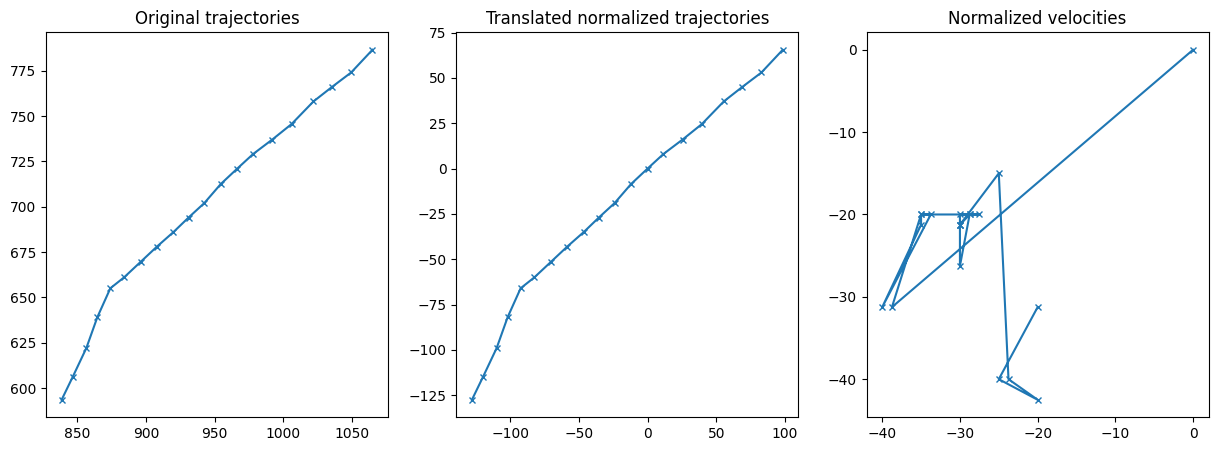

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs[0].set_title("Original trajectories");
axs[1].set_title("Translated normalized trajectories");
axs[2].set_title("Normalized velocities");
axs[0].plot(traj[:, 0], traj[:, 1], marker="x",markersize=4);
axs[1].plot(norm_traj[:, 0], norm_traj[:, 1], marker="x", markersize=4);
axs[2].plot(norm_velocities[:, 0], norm_velocities[:, 1], marker="x", markersize=4);


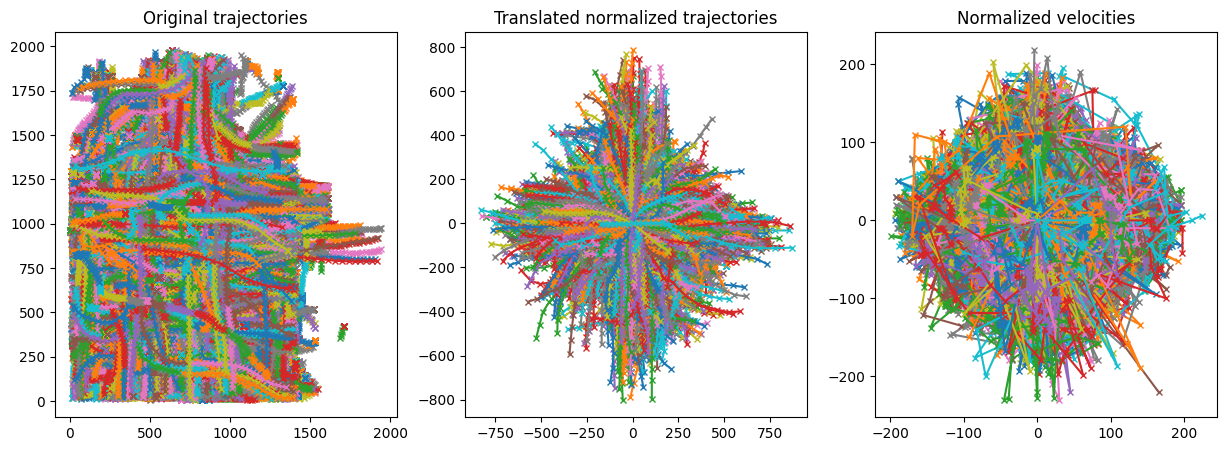

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs[0].set_title("Original trajectories");
axs[1].set_title("Translated normalized trajectories");
axs[2].set_title("Normalized velocities");
for sample in dataset:
    traj = sample["trajectories"]
    norm_traj = sample["normalized_trajectory"]
    norm_velocities = sample["speeds"]
    axs[0].plot(traj[:, 0], traj[:, 1], marker="x",markersize=4);
    axs[1].plot(norm_traj[:, 0], norm_traj[:, 1], marker="x", markersize=4);
    axs[2].plot(norm_velocities[:, 0], norm_velocities[:, 1], marker="x", markersize=4);